In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import gym

import math, random, time
import matplotlib.pyplot as plt

In [2]:
env = gym.make('CartPole-v0')

seed_value = 23
env.seed(seed_value)
torch.manual_seed(seed_value)
random.seed(seed_value)

In [13]:
# PARAMS

learning_rate = 0.02
num_episodes = 500
gamma = 1

hidden_layer = 64

egreedy = 0.9
egreedy_final = 0
egreedy_decay = 500

report_interval = 10
score_to_solve = 195

replay_mem_size = 50000
batch_size = 32

In [4]:
number_of_inputs = env.observation_space.shape[0]
number_of_outputs = env.action_space.n

def calculate_epsilon(steps_done):
    return egreedy_final + (egreedy - egreedy_final) * math.exp(-1 * steps_done / egreedy_decay)

In [5]:
class ExperienceReplay(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
 
    def push(self, state, action, new_state, reward, done):
        transition = (state, action, new_state, reward, done)
        
        if self.position >= len(self.memory):
            self.memory.append(transition)
        else:
            self.memory[self.position] = transition
        
        self.position = ( self.position + 1 ) % self.capacity
        
        
    def sample(self, batch_size):
        return zip(*random.sample(self.memory, batch_size))
        
        
    def __len__(self):
        return len(self.memory)

In [6]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(number_of_inputs, hidden_layer)
        self.linear2 = nn.Linear(hidden_layer, number_of_outputs)
        self.activation = nn.Tanh()
#         self.activation = nn.ReLU()
        
    def forward(self, x):
        output1 = self.linear1(x)
        output1 = self.activation(output1)
        return self.linear2(output1)
        

In [17]:
class QNetAgent(object):
    def __init__(self):
        self.nn = NeuralNetwork()
        self.loss_func = nn.MSELoss()
        self.optimizer = optim.Adam(params=self.nn.parameters(), lr=learning_rate)
        
    def select_action(self, state, epsion):
        random_for_egreedy = torch.rand(1)[0]
        
        if random_for_egreedy > epsilon:
            with torch.no_grad():
                state = torch.Tensor(state)
                action_from_nn = self.nn(state)
                action = torch.max(action_from_nn, 0)[1]
                action = action.item()
        else:
            action = env.action_space.sample()
            
        return action
    
    def optimize(self):
        if (len(memory) < batch_size):
            return
        
        state, action, new_state, reward, done = memory.sample(batch_size)
        
        state = torch.Tensor(state) #.to(device)
        new_state = torch.Tensor(new_state) #.to(device)
        reward = torch.Tensor(reward) #.to(device)
        action = torch.LongTensor(action) #.to(device)
        done = torch.Tensor(done) #.to(device)

        new_state_values = self.nn(new_state).detach()
        max_new_state_values = torch.max(new_state_values, 1)[0]
        target_value = reward + ( 1 - done ) * gamma * max_new_state_values
  
        predicted_value = self.nn(state).gather(1, action.unsqueeze(1)).squeeze(1)
        
        loss = self.loss_func(predicted_value, target_value)
    
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()



*** Episode 0 ***                       
Av.reward: [last 10]: 1.20, [last 100]: 0.12, [all]: 12.00                       
epsilon: 0.88, frames_total: 12
Elapsed time:  00:00:00

*** Episode 10 ***                       
Av.reward: [last 10]: 37.20, [last 100]: 3.84, [all]: 34.91                       
epsilon: 0.42, frames_total: 384
Elapsed time:  00:00:00

*** Episode 20 ***                       
Av.reward: [last 10]: 175.70, [last 100]: 21.41, [all]: 101.95                       
epsilon: 0.01, frames_total: 2141
Elapsed time:  00:00:01

*** Episode 30 ***                       
Av.reward: [last 10]: 187.30, [last 100]: 40.14, [all]: 129.48                       
epsilon: 0.00, frames_total: 4014
Elapsed time:  00:00:03

*** Episode 40 ***                       
Av.reward: [last 10]: 192.40, [last 100]: 59.38, [all]: 144.83                       
epsilon: 0.00, frames_total: 5938
Elapsed time:  00:00:05

*** Episode 50 ***                       
Av.reward: [last 10]: 200.00, [la


*** Episode 440 ***                       
Av.reward: [last 10]: 200.00, [last 100]: 199.79, [all]: 193.10                       
epsilon: 0.00, frames_total: 85155
Elapsed time:  00:01:15

*** Episode 450 ***                       
Av.reward: [last 10]: 200.00, [last 100]: 199.79, [all]: 193.25                       
epsilon: 0.00, frames_total: 87155
Elapsed time:  00:01:17

*** Episode 460 ***                       
Av.reward: [last 10]: 196.80, [last 100]: 199.47, [all]: 193.33                       
epsilon: 0.00, frames_total: 89123
Elapsed time:  00:01:19

*** Episode 470 ***                       
Av.reward: [last 10]: 200.00, [last 100]: 199.47, [all]: 193.47                       
epsilon: 0.00, frames_total: 91123
Elapsed time:  00:01:20

*** Episode 480 ***                       
Av.reward: [last 10]: 200.00, [last 100]: 199.47, [all]: 193.60                       
epsilon: 0.00, frames_total: 93123
Elapsed time:  00:01:22

*** Episode 490 ***                       
Av.rew

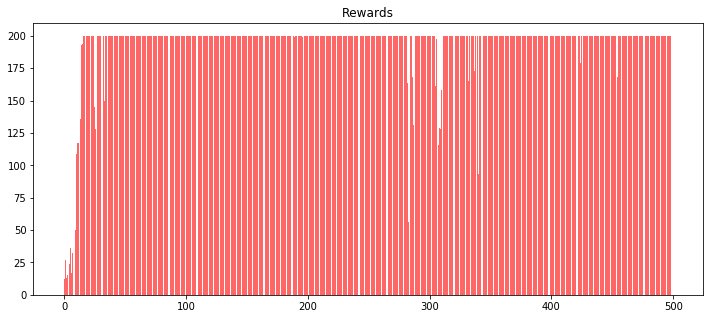

In [18]:
qnet_agent = QNetAgent()
memory = ExperienceReplay(replay_mem_size)

steps_total = []
frames_total = 0
solved_after = 0
solved = False

start_time = time.time()

for i_episode in range(num_episodes):
    
    state = env.reset()
    
    step = 0
    while True:
        
        step += 1
        frames_total += 1
        
        epsilon = calculate_epsilon(frames_total)
        
        action = qnet_agent.select_action(state, epsilon)
        
        new_state, reward, done, info = env.step(action)

        memory.push(state, action, new_state, reward, done)
        qnet_agent.optimize()
        
        state = new_state
        
        if done:
            steps_total.append(step)
            
            mean_reward_100 = sum(steps_total[-100:])/100
            
            if (mean_reward_100 > score_to_solve and solved == False):
                print("SOLVED! After %i episodes " % i_episode)
                solved_after = i_episode
                solved = True
            
            if (i_episode % report_interval == 0):
                
                
                
                print("\n*** Episode %i *** \
                      \nAv.reward: [last %i]: %.2f, [last 100]: %.2f, [all]: %.2f \
                      \nepsilon: %.2f, frames_total: %i" 
                  % 
                  ( i_episode,
                    report_interval,
                    sum(steps_total[-report_interval:])/report_interval,
                    mean_reward_100,
                    sum(steps_total)/len(steps_total),
                    epsilon,
                    frames_total
                          ) 
                  )
                  
                elapsed_time = time.time() - start_time
                print("Elapsed time: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))



            break


print("Average reward: %.2f" % (sum(steps_total)/num_episodes))
print("Average number of steps (last 100 episodes): %.2f" % (sum(steps_total[-100:])/100))
if solved:
      print("Solved after %i episodes" % solved_after)
plt.figure(figsize=(12,5))
plt.title("Rewards")
plt.bar(torch.arange(len(steps_total)), steps_total, alpha=0.6, color='red')
plt.show()
      
env.close()
env.env.close()